In [1]:
import numpy as np
import pickle

from asterixdb.asterixdb import AsterixConnection
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/anders1991/miniconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Connect to Asterix and get ratings data

In [2]:
con = AsterixConnection(server='http://localhost', port=19002)

In [3]:
rated = con.query('''
    USE FactMap;
    
    SELECT r.*
    FROM reviews r
    WHERE r.reviewRating.bestRating >= r.reviewRating.ratingValue
    AND r.reviewRating.ratingValue >= r.reviewRating.worstRating
    AND r.reviewRating.bestRating > r.reviewRating.worstRating;
''').results

len(rated)

25477

In [4]:
unrated = con.query('''
    USE FactMap;
    
    SELECT r.*
    FROM reviews r
    WHERE NOT (r.reviewRating.bestRating >= r.reviewRating.ratingValue
    AND r.reviewRating.ratingValue >= r.reviewRating.worstRating
    AND r.reviewRating.bestRating > r.reviewRating.worstRating)
    OR is_null(r.reviewRating.ratingValue)
    OR is_null(r.reviewRating.worstRating)
    OR is_null(r.reviewRating.bestRating);
''').results

len(unrated)

34597

In [5]:
t = Tokenizer()
all_texts = [r['reviewRating']['alternateName'] for r in rated + unrated]
t.fit_on_texts(all_texts)

vocab_size = len(t.word_index) + 1
max_length = max([len(x['reviewRating']['alternateName']) for x in rated + unrated])

Create embedding matrix

In [6]:
def word2Vec(word):
    try:
        vec = con.query('''USE FactMap;
            SELECT vector
            FROM fasttext f
            WHERE f.word = "{0}"
            ;'''.format(word)).results[0]['vector']
        return vec
    except:
        return None

In [7]:
embedding_matrix = np.zeros((vocab_size, 300))
embedding_matrix_oov = np.zeros((vocab_size, 300))

for word, idx in t.word_index.items():
    vec = word2Vec(word)
    if vec is not None:
        embedding_matrix[idx] = vec
    else:
        random_vec = [np.random.random(1)[0] for x in range(300)]
        embedding_matrix_oov[idx] = random_vec

In [8]:
with open('/Users/anders1991/Github/FactMap/RNN/data/embedding_matrix.pickle', 'wb') as f:
    pickle.dump(embedding_matrix, f, pickle.HIGHEST_PROTOCOL)

with open('/Users/anders1991/Github/FactMap/RNN/data/embedding_matrix_oov.pickle', 'wb') as f:
    pickle.dump(embedding_matrix_oov, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# token <-> word conversion
word2token = {w: tk for w, tk in t.word_index.items()}
token2word = dict(map(reversed, t.word_index.items()))

with open('/Users/anders1991/Github/FactMap/RNN/data/word2token.pickle', 'wb') as f:
    pickle.dump(word2token, f, pickle.HIGHEST_PROTOCOL)
    
with open('/Users/anders1991/Github/FactMap/RNN/data/token2word.pickle', 'wb') as f:
    pickle.dump(token2word, f, pickle.HIGHEST_PROTOCOL)

Create {r.uid: tokenized_seq, tokenized_seq_oov, isFake} dicts for both rated and unrated data

In [10]:
rated_tokenized = t.texts_to_sequences([r['reviewRating']['alternateName'] for r in rated])
unrated_tokenized = t.texts_to_sequences([r['reviewRating']['alternateName'] for r in unrated])

rated_padded = pad_sequences(rated_tokenized, maxlen=max_length, padding='post')
unrated_padded = pad_sequences(unrated_tokenized, maxlen=max_length, padding='post')

In [11]:
def isFake(r):
    """Returns True if rating is at most 50%, False otherwise."""
    bestDiff = r['reviewRating']['bestRating'] - r['reviewRating']['ratingValue']
    worstDiff = r['reviewRating']['ratingValue'] - r['reviewRating']['worstRating']
    return bestDiff >= worstDiff

unrated_ids = [r['uid'] for r in unrated]
rated_ids = [r['uid'] for r in rated]
rated_isFake = [isFake(r) for r in rated]

In [12]:
def isOov(token, embedding_matrix):
    """Returns True if token is out of vocabulary, False otherwise. Returns None padded values (0)."""
    if token == 0:
        return None
    elif np.sum(embedding_matrix[token,:]) == 0:
        return True
    else:
        return False

In [30]:
rated_data = dict()
for r in zip(rated_ids, rated_padded, rated_isFake):
    ID = r[0]
    tokenized_desc = np.array([x if not isOov(x, embedding_matrix) else 0 for x in r[1]])
    tokenized_desc_oov = np.array([x if isOov(x, embedding_matrix) else 0 for x in r[1]])
    isFake = r[2]
    rated_data[ID] = ((tokenized_desc, tokenized_desc_oov), isFake)

In [31]:
unrated_data = dict()
for r in zip(unrated_ids, unrated_padded):
    ID = r[0]
    tokenized_desc = np.array([x if not isOov(x, embedding_matrix) else 0 for x in r[1]])
    tokenized_desc_oov = np.array([x if isOov(x, embedding_matrix) else 0 for x in r[1]])
    unrated_data[ID] = (tokenized_desc, tokenized_desc_oov)

In [32]:
with open('/Users/anders1991/Github/FactMap/RNN/data/data_rated.pickle', 'wb') as f:
    pickle.dump(rated_data, f, pickle.HIGHEST_PROTOCOL)

with open('/Users/anders1991/Github/FactMap/RNN/data/data_unrated.pickle', 'wb') as f:
    pickle.dump(unrated_data, f, pickle.HIGHEST_PROTOCOL)

----

### RNN

In [118]:
with open('./data/data_rated.pickle', 'rb') as f:
    rated_data = pickle.load(f)

with open('./data/data_unrated.pickle', 'rb') as f:
    unrated_data = pickle.load(f)

In [119]:
with open('./data/embedding_matrix.pickle', 'rb') as f:
    embedding_matrix = pickle.load(f)

with open('./data/embedding_matrix_oov.pickle', 'rb') as f:
    embedding_matrix_oov = pickle.load(f)

Remember to insert embedding matrices into RNN (lock pretrained embeddings, unlock random out of vocab embeddings).

In [101]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM
from keras.layers.merge import add
from keras.layers.wrappers import Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

rnn_in = Input(shape=(max_length,), name='rnn_in')
rnn = Embedding(input_dim=vocab_size, 
                output_dim=300, 
                input_length=max_length,
                weights=[embedding_matrix],
                embeddings_initializer=Constant(embedding_matrix),
                trainable=False,
                mask_zero=True,
                name="embedding")(rnn_in)

rnn_in_oov = Input(shape=(max_length,), name='rnn_in_oov')
rnn_oov = Embedding(input_dim=vocab_size, 
                    output_dim=300, 
                    input_length=max_length,
                    weights=[embedding_matrix_oov],
                    embeddings_initializer=Constant(embedding_matrix_oov),
                    trainable=True,
                    mask_zero=True,
                    name="embedding_oov")(rnn_in_oov)

rnn = add([rnn, rnn_oov], name='add')
rnn = Bidirectional(LSTM(32, return_sequences=True), name="bi_lstm_1")(rnn)
rnn = Bidirectional(LSTM(32, return_sequences=True), name="bi_lstm_2")(rnn)
rnn_out = LSTM(1, activation='sigmoid', return_sequences=False, name="lstm_out")(rnn)
# rnn_out = Dense(1, activation='sigmoid')(rnn)

rnn = Model(inputs=[rnn_in, rnn_in_oov], outputs=rnn_out)

rnn.compile(loss='binary_crossentropy',
            optimizer=Adam(lr=1e-3),
            metrics=['accuracy'])

In [102]:
rnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_in (InputLayer)             (None, 500)          0                                            
__________________________________________________________________________________________________
rnn_in_oov (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 300)     2282100     rnn_in[0][0]                     
__________________________________________________________________________________________________
embedding_oov (Embedding)       (None, 500, 300)     2282100     rnn_in_oov[0][0]                 
__________________________________________________________________________________________________
add (Add) 

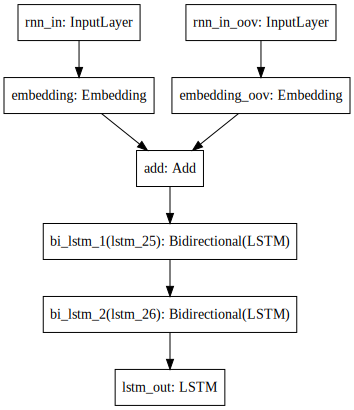

In [103]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(rnn).create(prog='dot', format='svg'))

Shuffle IDs and split into train/val

In [46]:
ids = list(rated_data.keys())
np.random.seed(2)
np.random.shuffle(ids)

trainFrac = 0.7
validFrac = 0.2

partition = dict()
partition["train"] = {ID: rated_data[ID] for ID in ids[:int(len(ids)*trainFrac)]}
partition["valid"] = {ID: rated_data[ID] for ID in ids[int(len(ids)*trainFrac):int(len(ids)*(trainFrac + validFrac))]}
partition["test"] = {ID: rated_data[ID] for ID in ids[int(len(ids)*(trainFrac + validFrac)):]}

Define data generator

In [126]:
def generator(partition, mode="train", batch_size=16, predict=False):
    X = np.zeros(shape=(batch_size, max_length), dtype=int)
    X_oov = X = np.zeros(shape=(batch_size, max_length), dtype=int)
    if not predict:
        y = np.zeros(shape=(batch_size, 1), dtype=int)
    val_idx = 0

    while True:
        ids = list(partition[mode].keys())
        if mode == "train":
            batch_ids = np.random.choice(ids, batch_size)
        elif mode == "valid":
            batch_ids = ids[val_idx:val_idx+batch_size]  # eval every sample once
            val_idx += batch_size
        
        for i, ID in enumerate(batch_ids):
            (seq, seq_oov), tgt = partition[mode][ID]
            X[i,:] = seq
            X_oov[i,:] = seq_oov
            if not predict:
                y[i,:] = tgt
            
            out = [X, X_oov], y if not predict else [X, X_oov]
            yield out

Create train and validation data generators

In [129]:
batch_size = 16
train_steps_per_epoch = len(partition['train'].keys()) // batch_size
valid_steps_per_epoch = len(partition['valid'].keys()) // batch_size

gen_train = generator(partition=partition, mode='train', batch_size=batch_size)
gen_valid = generator(partition=partition, mode='valid', batch_size=batch_size)

In [130]:
(X, X_oov), y = gen_train.__next__()
print(X.shape, X_oov.shape, y.shape)

(16, 500) (16, 500) (16, 1)


In [132]:
n_epochs = 50

hist = rnn.fit_generator(generator=gen_train, 
                         steps_per_epoch=train_steps_per_epoch,
                         epochs=n_epochs,
                         validation_data=gen_valid,
                         validation_steps=valid_steps_per_epoch,
                         verbose=1)

----